# Introduction
    This script is designed to analyze and clean the NFL Big Data Bowl dataset, train predictive models, and generate insights into offensive play design. It includes functions for data loading, analysis, cleaning, and model training, with a focus on identifying patterns and trends in play data.


This project aims to analyze and clean the NFL Big Data Bowl dataset, focusing on offensive play design and predictive modeling. 

One critical aspect of football strategy is the "red zone," which refers to the area within 20 yards of the opponent's end zone. 

Plays executed in this zone are crucial as they often determine the outcome of the game, making it essential for teams to optimize their strategies in these situations.



The recommendation system developed in this project will assist coaches by providing data-driven insights into effective play calls during red zone situations. 

By analyzing historical play data, the system can suggest optimal plays based on various factors such as defensive formations, player performance, and situational context, ultimately enhancing decision-making and increasing the chances of scoring.

# Code

## Imports

In [343]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import concurrent.futures
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns


## Data Loading

In [3]:
# Initialize global dictionary to store all dataframes
dataframes = {}

def load_all_data():
    """
    Load all CSV files from the data directory into a global dictionary.
    
    This function:
    1. Looks for CSV files in the 'data' directory
    2. Uses parallel processing to load files efficiently
    3. For each file, prints diagnostic information including:
       - Shape of the dataframe
       - First 5 rows preview
       - Count of null values
       - Column names
    4. Stores each dataframe in the global 'dataframes' dictionary
    
    Returns:
        bool: True if loading succeeds, False if there are any errors
    """
    global dataframes  # Declare that we are using the global 'dataframes' variable
    data_directory = 'data'  # Define the directory where data files are stored
    
    # Check if data directory exists
    if not os.path.exists(data_directory):
        print(f"Error: Directory '{data_directory}' not found!")
        return False
        
    try:
        # Get list of CSV files and their full paths
        csv_files = [filename for filename in os.listdir(data_directory) if filename.endswith('.csv')]
        filepaths = [os.path.join(data_directory, filename) for filename in csv_files]

        def load_file(filepath):
            """
            Helper function to load a single CSV file and print diagnostic information
            
            Args:
                filepath: Path to the CSV file
                
            Returns:
                pandas.DataFrame: Loaded dataframe
            """
            df = pd.read_csv(filepath)  # Load the CSV file into a DataFrame
            # Print diagnostic information about the loaded file
            print(df.columns)  # Display the column names of the DataFrame
            return df  # Return the loaded DataFrame

        # Use ThreadPoolExecutor for parallel file loading
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(executor.map(load_file, filepaths))  # Load files in parallel
            # Store each dataframe in the global dictionary
            for filename, df in zip(csv_files, results):
                dataframes[filename] = df  # Map filename to its corresponding DataFrame

        print("\nData loading complete!")  # Indicate that loading is finished
        return True  # Return True to indicate success
    except Exception as e:
        print(f"Error loading data: {str(e)}")  # Print any error that occurs
        return False  # Return False to indicate failure


## Load all data

In [344]:
load_all_data()

Index(['gameId', 'season', 'week', 'gameDate', 'gameTimeEastern',
       'homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore',
       'visitorFinalScore'],
      dtype='object')
Index(['nflId', 'height', 'weight', 'birthDate', 'collegeName', 'position',
       'displayName'],
      dtype='object')
Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSne

True

## Data Analysis
### This cell is optional, it was used to analyze the data and provide recommendations for data cleaning

In [345]:
def analyze_files(dataframes):
    """
    Analyze the provided dataframes for missing values and outliers, 
    and provide recommendations for data cleaning.

    Args:
        dataframes (dict): A dictionary where keys are dataframe names 
                           and values are the corresponding pandas DataFrames.
    """
    # Iterate through each dataframe in the provided dictionary
    for name, df in dataframes.items():
        print(f"\n{'='*50}\nAnalyzing {name}...\n{'='*50}")
        
        print(f'{name}')
        
        # Analyze missing values in detail
        missing_values = df.isnull().sum()  # Count missing values for each column
        missing_pct = (df.isnull().sum() / len(df)) * 100  # Calculate percentage of missing values
        
        # Check if there are any missing values in the dataframe
        if missing_values.any():
            print("\nMissing Values Analysis:")
            for col in df.columns:
                if missing_values[col] > 0:  # If the column has missing values
                    print(f"\nColumn: {col}")
                    print(f"Missing values: {missing_values[col]} ({missing_pct[col]:.2f}%)")
                    
                    # Display one row with a missing value and one with data (showing only a few columns)
                    print("\nExample Rows:")
                    missing_row = df[df[col].isnull()].iloc[0] if not df[df[col].isnull()].empty else None
                    data_row = df[df[col].notnull()].iloc[0] if not df[df[col].notnull()].empty else None
                    
                    if missing_row is not None:
                        print("Row with missing value:")
                        print(missing_row[:4])  # Show first 4 columns of the row with missing value
                    
                    if data_row is not None:
                        print("Row with data:")
                        print(data_row[:4])  # Show first 4 columns of the row with data
                    
                    # Analyze patterns in missing data
                    print("\nPattern Analysis:")
                    
                    # Check if missing values are concentrated in specific games
                    if 'gameId' in df.columns:
                        missing_by_game = df[df[col].isnull()]['gameId'].value_counts()
                        if len(missing_by_game) < len(df['gameId'].unique()) * 0.5:
                            print("- Missing values appear to be concentrated in specific games")
                    
                    # Check if missing values are related to specific teams
                    if 'possessionTeam' in df.columns:
                        missing_by_team = df[df[col].isnull()]['possessionTeam'].value_counts()
                        if len(missing_by_team) < len(df['possessionTeam'].unique()) * 0.5:
                            print("- Missing values appear to be team-specific")
                    
                    # Analyze data type and suggest handling strategy
                    dtype = df[col].dtype  # Get the data type of the column
                    non_null_values = df[col].dropna()  # Get non-null values for further analysis
                    
                    print("\nRecommended Action:")
                    
                    # Assess the percentage of missing values and provide recommendations
                    if missing_pct[col] < 5:
                        print("- Low Missingness (<5%): Generally safe to impute missing values.")
                    elif 5 <= missing_pct[col] <= 30:
                        print("- Moderate Missingness (5%-30%): Imputation is possible but requires careful consideration.")
                    else:
                        print("- High Missingness (>30%): Imputation may introduce significant bias; consider dropping the column or using advanced imputation methods.")
                    
                    # Recommendations based on data type
                    if dtype == 'object':
                        # Categorical data recommendations
                        unique_vals = non_null_values.nunique()  # Count unique non-null values
                        if unique_vals < 10:
                            print(f"- This appears to be a categorical column with {unique_vals} unique values")
                            mode_val = non_null_values.mode()[0]  # Get the mode of the column
                            print(f"- Consider filling missing values with mode '{mode_val}' or 'Unknown'")
                        else:
                            print("- This appears to be a text column with many unique values")
                            if missing_pct[col] > 50:
                                print("- Consider dropping this column due to high percentage of missing values")
                            else:
                                print("- Consider filling missing values with 'Unknown'")
                    
                    elif np.issubdtype(dtype, np.number):
                        # Numerical data recommendations
                        print(f"Statistical Summary of non-null values:")
                        print(non_null_values.describe())  # Display statistical summary
                        
                        if missing_pct[col] < 5:
                            print("- Low percentage of missing values")
                            print("- Consider filling with median")
                        elif missing_pct[col] > 50:
                            print("- High percentage of missing values")
                            print("- Consider dropping this column")
                        else:
                            print("Recommended options:")
                            print("1. Fill with mean")
                            print("2. Fill with median")
                            print("3. Fill with 0")
                            print("4. Drop column")
                    
                    elif dtype == 'bool':
                        print("- Boolean column")
                        print("- Consider filling missing values with False")
                    
                    elif dtype == 'datetime64[ns]':
                        print("- DateTime column")
                        if 'gameId' in df.columns:
                            print("- Consider filling missing dates based on gameId using forward fill")
        
        # Check for outliers in numerical columns
        print("\nOutlier Analysis:")
        numerical_cols = df.select_dtypes(include=[np.number]).columns  # Select numerical columns
        for col in numerical_cols:
            Q1 = df[col].quantile(0.25)  # Calculate the first quartile
            Q3 = df[col].quantile(0.75)  # Calculate the third quartile
            IQR = Q3 - Q1  # Calculate the interquartile range
            outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]  # Identify outliers
            if len(outliers) > 0:
                print(f"\nFound {len(outliers)} outliers in {col}")
                print("- Consider capping outliers at 1.5 IQR")  # Suggest capping outliers

# Call the function to analyze the dataframes and get recommendations
analyze_files(dataframes)



Analyzing plays.csv...
plays.csv

Missing Values Analysis:

Column: yardlineSide
Missing values: 224 (1.39%)

Example Rows:
Row with missing value:
gameId                                                    2022100907
playId                                                          2546
playDescription    (6:52) Br.Hall right guard to MIA 45 for 5 yar...
quarter                                                            3
Name: 227, dtype: object
Row with data:
gameId                                                    2022102302
playId                                                          2655
playDescription    (1:54) (Shotgun) J.Burrow pass short middle to...
quarter                                                            3
Name: 0, dtype: object

Pattern Analysis:

Recommended Action:
- Low Missingness (<5%): Generally safe to impute missing values.
- This appears to be a text column with many unique values
- Consider filling missing values with 'Unknown'

Column: offenseFormat

## Data Cleaning, Filtering, and Feature Engineering

### Games Data
This is mostly to make sure that we are only looking at games that are in this dataset.

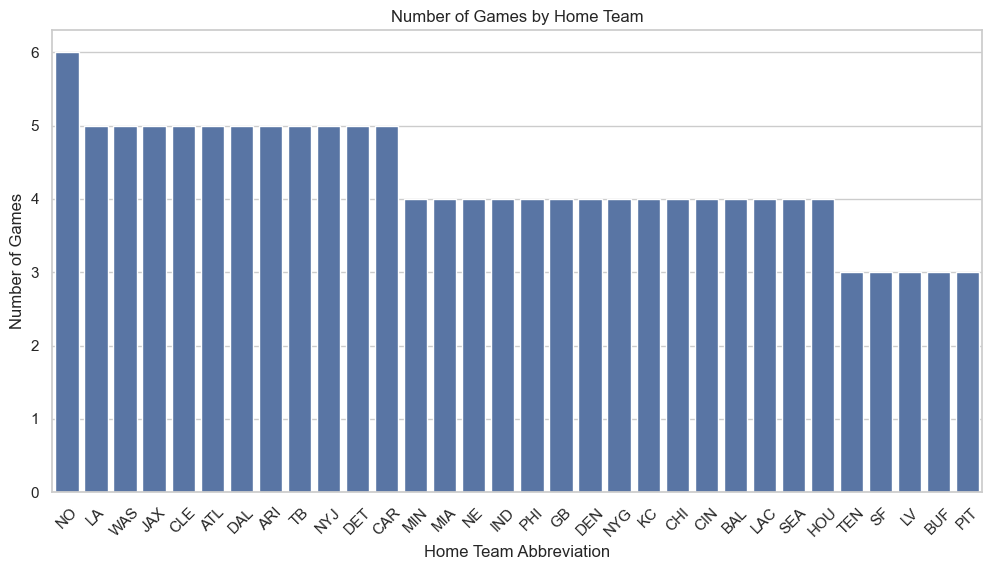

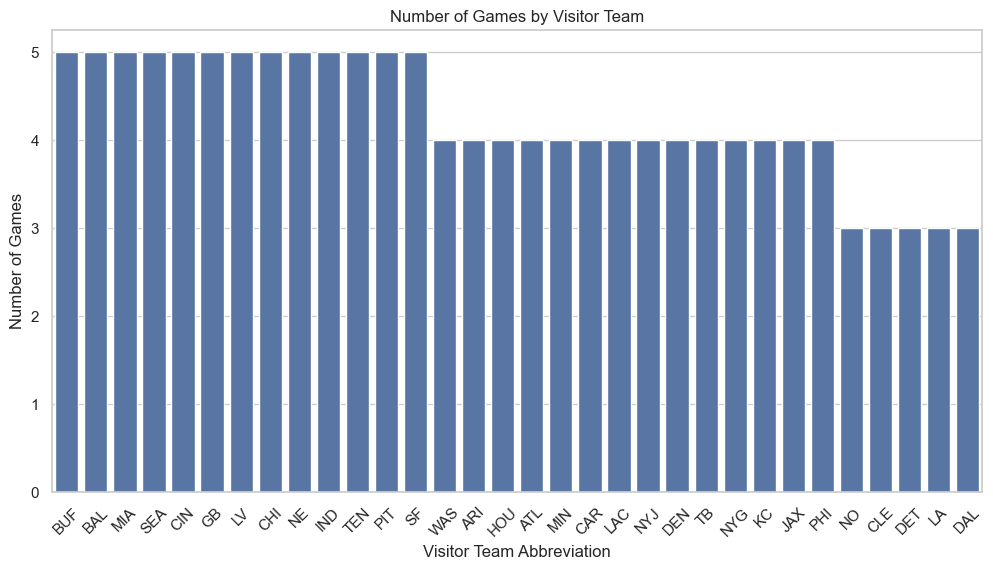

In [346]:
# Assuming 'dataframes' is a dictionary containing the loaded dataframes
games_df = dataframes['games.csv']  # Load the games dataframe from the dataframes dictionary

# Option to set a team filter or no filter
team_filter = 'KC'  # Specify the team abbreviation to filter by (e.g., 'KC' for Kansas City)

use_filter = False  # Set to False if you want to include all games; True to filter by team

# Check if filtering by team is enabled
if use_filter:
    # If filtering is enabled, keep only the rows for the specified team
    games_df = games_df[(games_df['homeTeamAbbr'] == team_filter) | (games_df['visitorTeamAbbr'] == team_filter)]
    # This line filters the games dataframe to include only games involving the specified team

import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a count plot for the number of games by home team
plt.figure(figsize=(12, 6))
sns.countplot(data=games_df, x='homeTeamAbbr', order=games_df['homeTeamAbbr'].value_counts().index)
plt.title('Number of Games by Home Team')
plt.xlabel('Home Team Abbreviation')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.show()

# Create a bar plot for the number of games by visitor team
plt.figure(figsize=(12, 6))
sns.countplot(data=games_df, x='visitorTeamAbbr', order=games_df['visitorTeamAbbr'].value_counts().index)
plt.title('Number of Games by Visitor Team')
plt.xlabel('Visitor Team Abbreviation')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.show()


## We will skip graphing more complex data for correlation and such given the large amount of columns and data

### Exploratory Data Analysis for Games Data

In [347]:
# Drop unnecessary columns to reduce data size
# Retaining only essential columns for further analysis
games_df = games_df[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']]  

# Print count of games
# Display the total number of games in the dataframe
print(f"Total number of games: {len(games_df)}")  

# Show the head of the filtered games dataframe
# Display the first few rows of the games dataframe for a quick overview
print(games_df.head())  

# Show the description of the filtered games dataframe
# Provide summary statistics of the dataframe to understand its distribution
print(games_df.describe())  

# Show the data types of the filtered games dataframe
# Display the data types of each column in the dataframe for type checking
print(games_df.dtypes)  

# Print missing values in the filtered games dataframe
# Calculate the number of missing values in each column
missing_values = games_df.isnull().sum()  
print("Missing values in each column:")  # Inform about missing values
# Display columns with missing values
print(missing_values[missing_values > 0])  

# Extract unique game IDs from the dataframe
# This will be used for filtering plays later
game_ids = games_df['gameId'].unique().tolist()  
print("Unique game IDs:", game_ids)  # Display the unique game IDs

# Save the edited dataframe back into the dataframes dictionary
# Update the dataframes dictionary with the modified games dataframe for future use
dataframes['games.csv'] = games_df  

# Count the number of unique gameIds
# This provides insight into the number of distinct games in the dataset
print(f"Number of unique gameIds: {len(game_ids)}")

Total number of games: 136
       gameId homeTeamAbbr visitorTeamAbbr
0  2022090800           LA             BUF
1  2022091100          ATL              NO
2  2022091101          CAR             CLE
3  2022091102          CHI              SF
4  2022091103          CIN             PIT
             gameId
count  1.360000e+02
mean   2.022099e+09
std    5.996614e+03
min    2.022091e+09
25%    2.022093e+09
50%    2.022101e+09
75%    2.022102e+09
max    2.022111e+09
gameId              int64
homeTeamAbbr       object
visitorTeamAbbr    object
dtype: object
Missing values in each column:
Series([], dtype: int64)
Unique game IDs: [2022090800, 2022091100, 2022091101, 2022091102, 2022091103, 2022091104, 2022091105, 2022091106, 2022091107, 2022091109, 2022091110, 2022091111, 2022091112, 2022091108, 2022091113, 2022091200, 2022091500, 2022091800, 2022091801, 2022091802, 2022091803, 2022091804, 2022091805, 2022091806, 2022091807, 2022091808, 2022091809, 2022091810, 2022091811, 2022091812, 202209190

### Plays
Cleaning and filtering the plays data

In [348]:
# print column names for plays csv
print(dataframes['plays.csv'].columns)

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

        gameId  playId                                    playDescription  \
0   2022102302    2655  (1:54) (Shotgun) J.Burrow pass short middle to...   
1   2022091809    3698  (2:13) (Shotgun) J.Burrow pass short right to ...   
2   2022103004    3146  (2:00) (Shotgun) D.Mills pass short right to D...   
3   2022110610     348  (9:28) (Shotgun) P.Mahomes pass short left to ...   
4   2022102700    2799  (2:16) (Shotgun) L.Jackson up the middle to TB...   
5   2022100205    2314  (14:15) Ja.Williams up the middle to DET 32 fo...   
6   2022110605    3861  (:29) (Shotgun) J.Wilkins up the middle to IND...   
7   2022100203    3994      (:35) K.Murray kneels to CAR 29 for -1 yards.   
8   2022091104    3662  (12:51) (Shotgun) J.Hurts pass incomplete shor...   
9   2022100204    1422  (5:22) (Shotgun) C.Rush pass short left to M.G...   
10  2022100912     445  (8:51) (Shotgun) C.Rush pass incomplete short ...   
11  2022102306    3240  (12:55) (Shotgun) A.Dillon left tackle to WAS ...   

/var/folders/gz/zygkt4mn4sd0g24rh8vb0z940000gn/T/ipykernel_10743/2586274813.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plays_df['unblockedPressure'] = plays_df['unblockedPressure'].fillna(False)


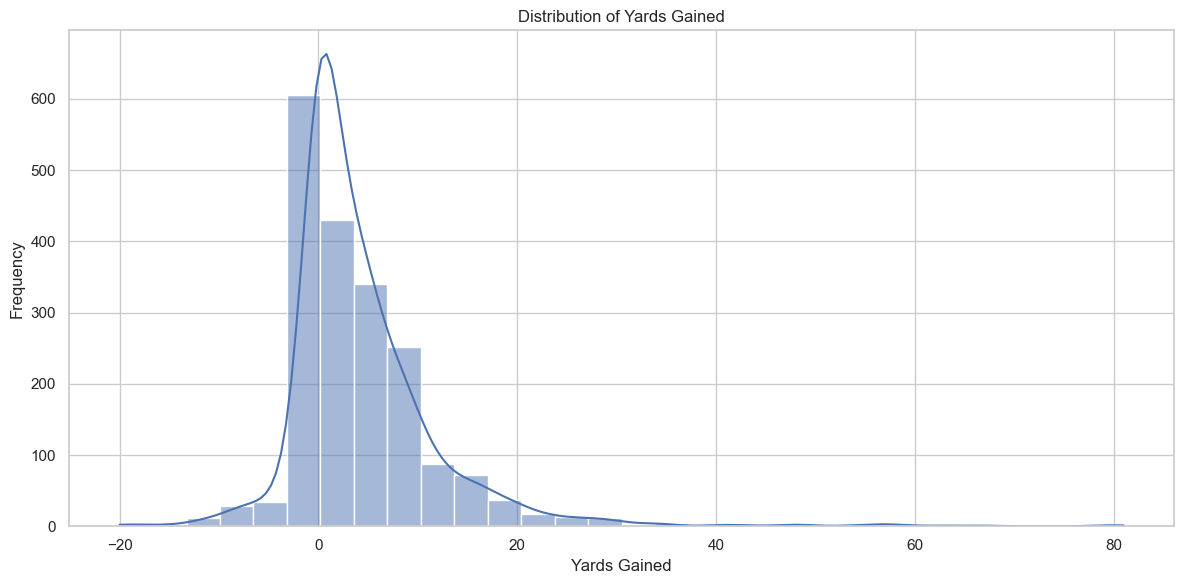

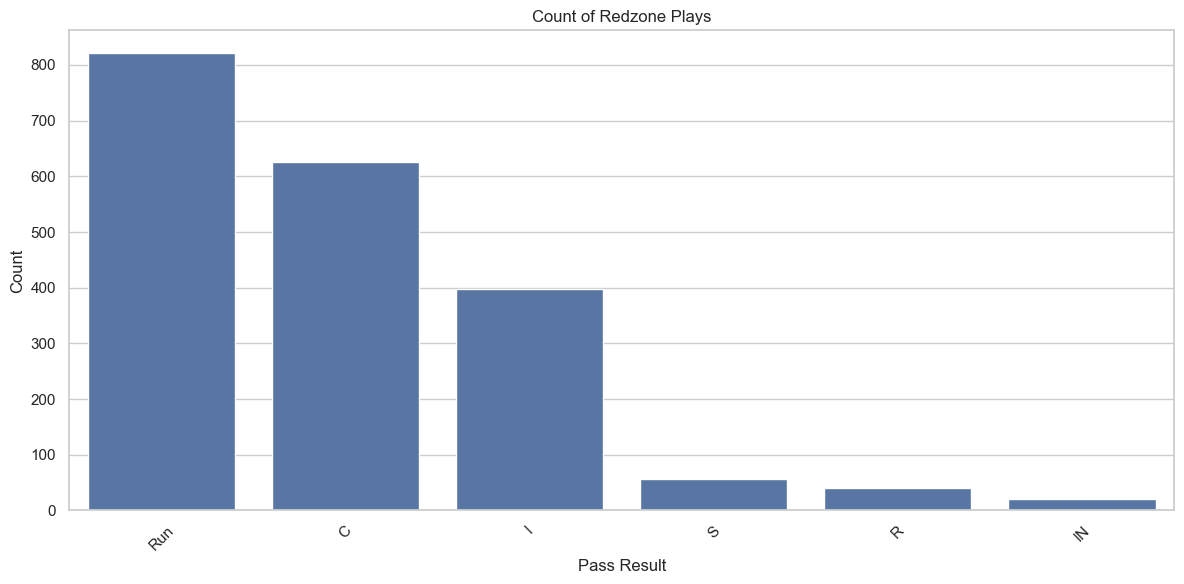

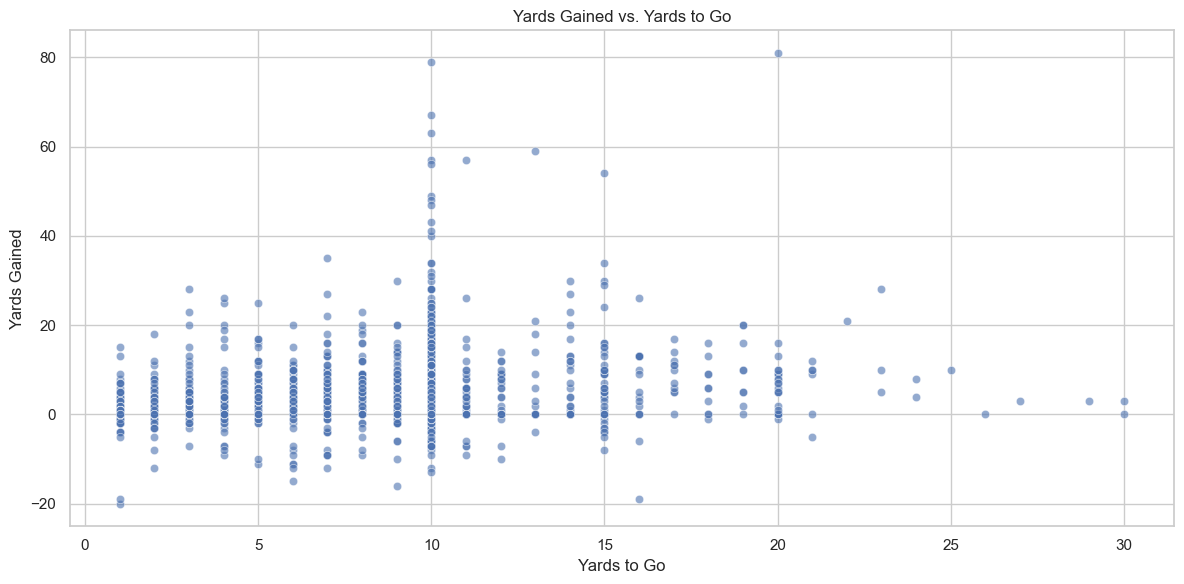

In [349]:
# Load the plays dataframe from the dataframes dictionary
plays_df = dataframes['plays.csv']

plays_df['passResult'] = plays_df['passResult'].fillna('Run')
plays_df['receiverAlignment'] = plays_df['receiverAlignment'].fillna('Unknown')
plays_df['offenseFormation'] = plays_df['offenseFormation'].fillna('Unknown')
plays_df['defensiveTeam'] = plays_df['defensiveTeam'].fillna('Unknown')
plays_df['yardsGained'] = plays_df['yardsGained'].fillna(0)
plays_df['prePenaltyYardsGained'] = plays_df['prePenaltyYardsGained'].fillna(0)
plays_df['unblockedPressure'] = plays_df['unblockedPressure'].fillna(False)
plays_df['isDropback'] = plays_df['isDropback'].fillna(False)
plays_df['passLength'] = plays_df['passLength'].fillna(0)
plays_df['targetX'] = plays_df['targetX'].fillna(0)
plays_df['targetY'] = plays_df['targetY'].fillna(0)
plays_df['expectedPointsAdded'] = plays_df['expectedPointsAdded'].fillna(0)

print(plays_df.head(50))

# Filter the dataframe to retain only the rows corresponding to the selected game IDs
plays_df = plays_df[plays_df['gameId'].isin(game_ids)]

# Apply a redzone filter to keep only plays where yardsToGo is less than or equal to 30 to determine a redzone play
plays_df = plays_df[plays_df['absoluteYardlineNumber'] <= 30]

# Drop all rows where offenseFormation is NA
plays_df = plays_df[plays_df['offenseFormation'] != 'NA']

# Check if a specific team filter is to be applied
if use_filter:
    # Filter the dataframe for plays where the defensive team and yardline side match the specified team
    plays_df = plays_df[(plays_df['defensiveTeam'] == team_filter) & (plays_df['yardlineSide'] == team_filter)]

# Remove rows where qbSpike is 1
plays_df = plays_df[plays_df['qbSpike'] != 1]

# Remove rows where qbKneel is 1
plays_df = plays_df[plays_df['qbKneel'] != 1]

# Remove rows where qbSneak is 1
plays_df = plays_df[plays_df['qbSneak'] != 1]

# Remove rows where playNullifiedByPenalty is True
plays_df = plays_df[plays_df['playNullifiedByPenalty'] != True]
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a histogram for yards gained
plt.figure(figsize=(12, 6))
sns.histplot(data=plays_df, x='yardsGained', bins=30, kde=True)
plt.title('Distribution of Yards Gained')
plt.xlabel('Yards Gained')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Create a bar plot for the count of pass results
plt.figure(figsize=(12, 6))
sns.countplot(data=plays_df, x='passResult', order=plays_df['passResult'].value_counts().index)
plt.title('Count of Redzone Plays')
plt.xlabel('Pass Result')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a scatter plot for yards gained vs. yards to go
plt.figure(figsize=(12, 6))
sns.scatterplot(data=plays_df, x='yardsToGo', y='yardsGained', alpha=0.6)
plt.title('Yards Gained vs. Yards to Go')
plt.xlabel('Yards to Go')
plt.ylabel('Yards Gained')
plt.tight_layout()
plt.show()


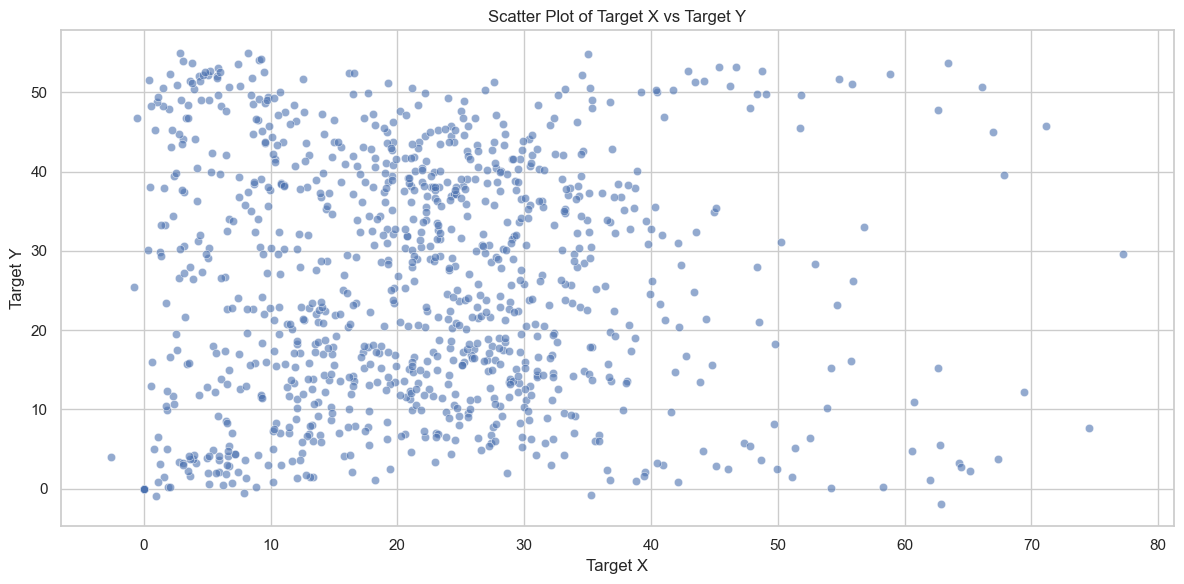

In [350]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=plays_df, x='targetX', y='targetY', alpha=0.6)
plt.title('Scatter Plot of Target X vs Target Y')
plt.xlabel('Target X')
plt.ylabel('Target Y')
plt.tight_layout()
plt.show()

In [351]:
# for each column print unique values
for column in plays_df.columns:
    print(f"Unique values in '{column}': {plays_df[column].unique()}")

Unique values in 'gameId': [2022091809 2022103004 2022100212 2022100913 2022100900 2022091109
 2022102302 2022092511 2022100908 2022101600 2022091811 2022100208
 2022103001 2022100213 2022091106 2022091810 2022110300 2022092507
 2022091110 2022092600 2022103003 2022100204 2022100209 2022091112
 2022110604 2022092508 2022102309 2022101611 2022101601 2022110606
 2022100902 2022091108 2022091803 2022100901 2022101300 2022102300
 2022090800 2022102000 2022092505 2022092502 2022110601 2022092501
 2022101609 2022110605 2022101604 2022110603 2022102301 2022103009
 2022091801 2022103007 2022100211 2022102307 2022110607 2022091802
 2022091500 2022101610 2022102310 2022100201 2022100200 2022103002
 2022091113 2022091807 2022100907 2022092513 2022102306 2022101000
 2022101605 2022101602 2022100903 2022100205 2022102304 2022091900
 2022100600 2022101606 2022092900 2022091102 2022091103 2022101607
 2022110609 2022092503 2022110610 2022091104 2022100911 2022103012
 2022102700 2022092510 2022110700 2

['C' 'Run' 'I' 'R' 'S' 'IN']


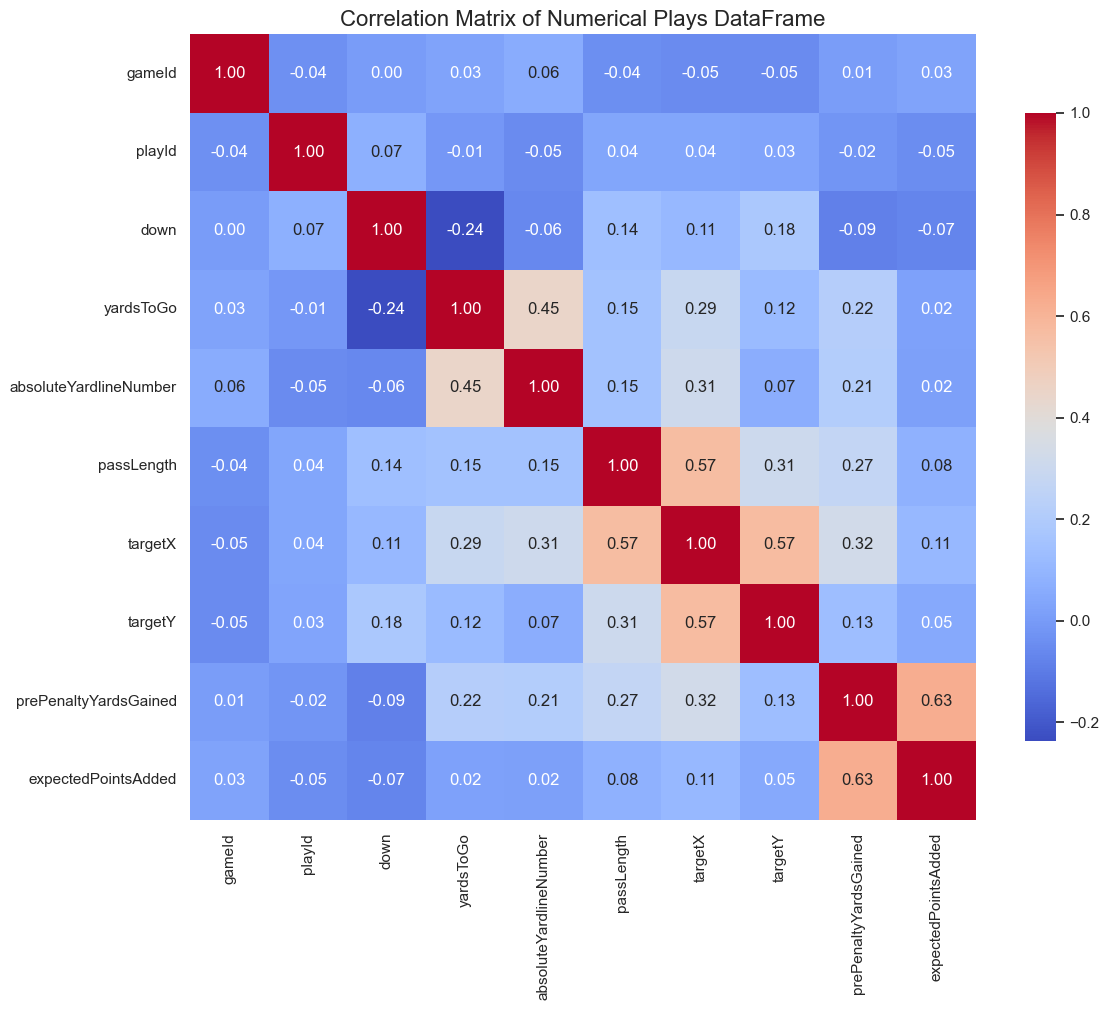

In [352]:
# Drop offenseFormation where it is NA
plays_df = plays_df[plays_df['offenseFormation'] != 'NA']

# Change name of pff_passCoverage to defenseFormation
plays_df = plays_df.rename(columns={'pff_passCoverage': 'defenseFormation'})

# Drop defenseFormation where it is Miscellaneous
plays_df = plays_df[plays_df['defenseFormation'] != 'Miscellaneous']

# print unique values from passResult, including NaN
print(plays_df['passResult'].unique())

# Save the unique values of playId to filter the tracking data
play_ids = plays_df['playId'].unique().tolist()

# Save the edited dataframe back into the dataframes dictionary for future use
dataframes['plays.csv'] = plays_df

# Define the essential columns needed for further analysis
essential_columns = [
    'gameId', 'playId', 'down', 'yardsToGo', 'absoluteYardlineNumber', 'offenseFormation', 
    'receiverAlignment', 'passResult', 'passLength', 'targetX', 
    'targetY', 'unblockedPressure', 
    'prePenaltyYardsGained', 'isDropback', 
    'defenseFormation', 'expectedPointsAdded', 'defensiveTeam', 'possessionTeam'
]

# Filter the dataframe to keep only the essential columns
plays_df = plays_df[essential_columns]

# Calculate the correlation matrix for only numerical columns
correlation_matrix = plays_df.select_dtypes(include=[np.number]).corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title of the heatmap
plt.title('Correlation Matrix of Numerical Plays DataFrame', fontsize=16)
plt.tight_layout()
plt.show()

In [353]:
# Print all unique values for each column in the dataframe
for column in plays_df.columns:
    print(f"Unique values in '{column}': {plays_df[column].unique()}")


Unique values in 'gameId': [2022091809 2022103004 2022100212 2022100913 2022100900 2022091109
 2022102302 2022092511 2022100908 2022101600 2022091811 2022100208
 2022103001 2022100213 2022091106 2022091810 2022110300 2022092507
 2022091110 2022092600 2022103003 2022100204 2022100209 2022091112
 2022110604 2022092508 2022102309 2022101611 2022101601 2022110606
 2022100902 2022091108 2022091803 2022100901 2022101300 2022102300
 2022090800 2022102000 2022092505 2022092502 2022110601 2022092501
 2022101609 2022110605 2022101604 2022110603 2022102301 2022103009
 2022091801 2022103007 2022100211 2022102307 2022110607 2022091802
 2022091500 2022101610 2022102310 2022100201 2022100200 2022103002
 2022091113 2022091807 2022100907 2022092513 2022102306 2022101000
 2022101605 2022101602 2022100903 2022100205 2022102304 2022091900
 2022100600 2022101606 2022092900 2022091102 2022091103 2022101607
 2022110609 2022092503 2022110610 2022091104 2022100911 2022103012
 2022102700 2022092510 2022110700 2

### Player Play
Cleaning and filtering the player play data

    hadRushAttempt  wasTargettedReceiver  rushingYards  hadDropback  \
66               0                     0             0            0   
67               0                     0             0            0   
68               0                     0             0            0   
69               0                     0             0            0   
70               0                     0             0            0   

    passingYards  wasRunningRoute routeRan pff_defensiveCoverageAssignment  \
66             0              0.0      NaN                         Unknown   
67             0              0.0      NaN                         Unknown   
68             0              1.0       GO                         Unknown   
69             0              0.0      NaN                         Unknown   
70             0              1.0     POST                         Unknown   

        gameId  playId  nflId  
66  2022090800     122  35472  
67  2022090800     122  42392  
68  2022

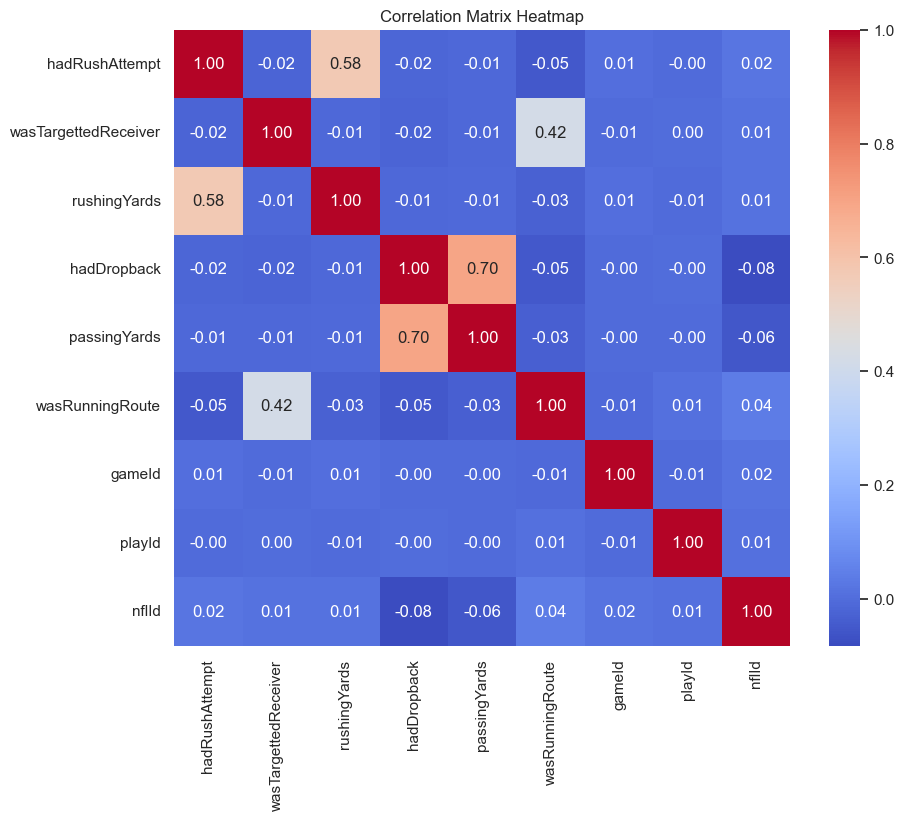

In [354]:
# Assuming 'dataframes' is a dictionary containing the loaded dataframes
players_df = dataframes['player_play.csv']  # Load the player-play dataframe from the dataframes dictionary

# Filter players_df to keep only the rows where gameId corresponds to the selected game IDs
players_df = players_df[players_df['gameId'].isin(game_ids)]  # Retain only the relevant games based on game IDs

# Filter players_df to keep only the rows where playId is in the list of play_ids
players_df = players_df[players_df['playId'].isin(play_ids)]  # Retain only the relevant plays based on play IDs

# Keep only the specified columns that are necessary for analysis
players_df = players_df[['hadRushAttempt', 'wasTargettedReceiver','rushingYards', 'hadDropback', 'passingYards', 
                          'wasRunningRoute', 'routeRan', 'pff_defensiveCoverageAssignment', 
                          'gameId', 'playId', 'nflId']]  # Select essential columns for further processing


# Fill missing values as per instructions
players_df['wasRunningRoute'] = players_df['wasRunningRoute'].fillna(0)  # Fill NaN with 0

# Fill pff_defensiveCoverageAssignment
players_df['pff_defensiveCoverageAssignment'] = players_df['pff_defensiveCoverageAssignment'].fillna('Unknown')  # Fill NaN with 'unknown'

# Show the head of the dataframe to get a glimpse of the data
print(players_df.head())  # Display the first few rows of the players dataframe

# Show the description of the dataframe to understand its statistical properties
print(players_df.describe())  # Provide summary statistics of the dataframe

# Show the data types of the dataframe to check the format of each column
print(players_df.dtypes)  # Display the data types of each column in the dataframe

# Print unique values of each column to figure out what to fill null values with
for column in players_df.columns:
    print(f"Unique values in '{column}': {players_df[column].unique()}")  # Display unique values for each column

# Print missing values in the players_df dataframe to identify any data quality issues
missing_values = players_df.isnull().sum()  # Calculate the number of missing values in each column
print("Missing values in each column:")  # Inform about missing values
print(missing_values[missing_values > 0])  # Display columns with missing values

# Save the edited dataframe back into the dataframes dictionary for future use
dataframes['player_play.csv'] = players_df  # Update the dataframes dictionary with the modified players dataframe

# Count the number of rows in the player play dataframe
print(f"Number of rows in the player play dataframe: {len(players_df)}")


# Calculate the correlation matrix for the players_df dataframe, considering only numerical columns
correlation_matrix = players_df.select_dtypes(include=[np.number]).corr()

# Display the correlation matrix
print("Correlation matrix:")
print(correlation_matrix)

# Optionally, visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()


### Tracking Data

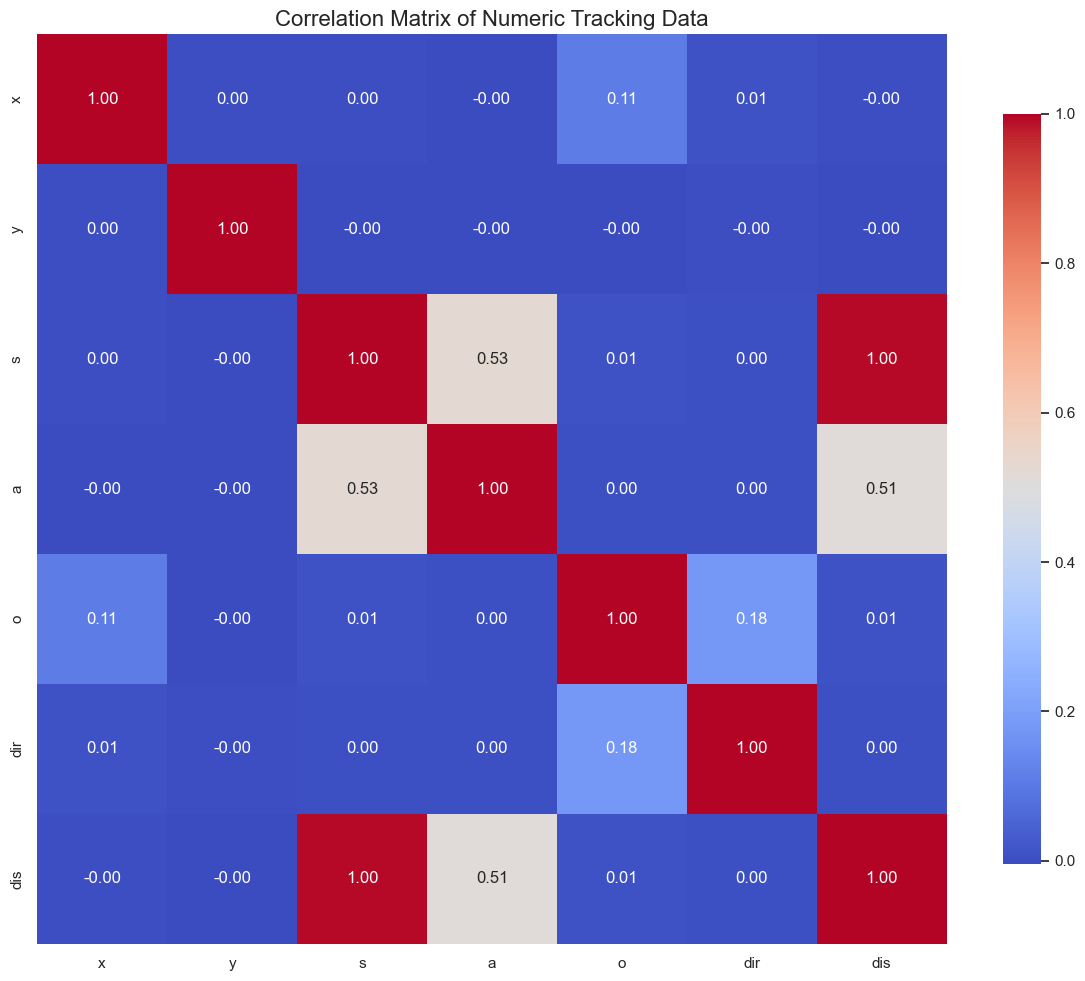

In [355]:
import pandas as pd
import glob
import re

# Get a list of all tracking data files using regex
tracking_files = [file for file in dataframes.keys() if re.match(r'tracking_.*\.csv', file)]

# Initialize an empty list to hold DataFrames
tracking_dfs = []

# Define relevant events
relevant_events = [
    'pass_outcome_touchdown', 
    'touchdown', 
    'pass_outcome_caught', 
    'pass_outcome_incomplete', 
    'pass_outcome_interception', 
    'run', 
    'handoff', 
    'fumble', 
    'safety', 
    'field_goal_play',
    'qb_sack',  # This can also be relevant as it indicates a failed play
    'dropped_pass'  # Indicates a missed opportunity
]

# Loop through each file and process it
for file in tracking_files:
    # Filter tracking_df to keep only the rows where playId corresponds to the selected play IDs
    tracking_df = dataframes[file]
    tracking_df = tracking_df[tracking_df['playId'].isin(play_ids)]  # Use play_ids for filtering

    tracking_df = tracking_df.dropna(subset=['x', 'y', 'o', 'dir', 'dis', 's', 'a'])
    
    # Select relevant columns
    tracking_df = tracking_df[['gameId', 'playId', 'nflId', 'frameType', 'frameId', 
                               'club', 'x', 'y', 'event', 'playDirection', 's', 'a', 'o', 'dir', 'dis']]
    
    # Filter to keep only BEFORE_SNAP frames
    tracking_df = tracking_df[tracking_df['frameType'] == 'BEFORE_SNAP']

    tracking_df = tracking_df.drop(columns=['frameType'])  # Drop the frameType column

    # Fill null values in 'event' with 'No Event'
    tracking_df['event'] = tracking_df['event'].fillna('No Event')
    
    # Drop rows where 'club' is 'football'
    tracking_df = tracking_df[tracking_df['club'] != 'football']
    
    # Append the processed DataFrame to the list
    tracking_dfs.append(tracking_df)

# Concatenate all DataFrames into a single DataFrame
dataframes['all_tracking_data'] = pd.concat(tracking_dfs, ignore_index=True)

# Select only numeric columns for correlation analysis
numeric_columns = ['x', 'y', 's', 'a', 'o', 'dir', 'dis']
numeric_df = dataframes['all_tracking_data'][numeric_columns]

# Calculate correlation matrix for numeric columns
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title of the heatmap
plt.title('Correlation Matrix of Numeric Tracking Data', fontsize=16)
plt.tight_layout()
plt.show()

Unique values in 'gameId': [2022101000 2022100913 2022100912 2022100911 2022100910 2022100909
 2022100908 2022100907 2022100906 2022100905 2022100904 2022100903
 2022100902 2022100901 2022100900 2022100600 2022100300 2022100213
 2022100212 2022100211 2022100203 2022100210 2022100209 2022100208
 2022100207 2022100206 2022100205 2022100204 2022100202 2022100201
 2022100200 2022092900 2022101700 2022101611 2022101610 2022101609
 2022101608 2022101607 2022101606 2022101605 2022101604 2022101603
 2022101602 2022101601 2022101600 2022101300 2022102400 2022102311
 2022102310 2022102309 2022102308 2022102307 2022102306 2022102305
 2022102304 2022102303 2022102302 2022102301 2022102300 2022102000
 2022092600 2022092513 2022092512 2022092511 2022092510 2022092509
 2022092508 2022092507 2022092506 2022092505 2022092504 2022092503
 2022092502 2022092501 2022092500 2022092200 2022091901 2022091900
 2022091812 2022091811 2022091810 2022091809 2022091808 2022091807
 2022091806 2022091805 2022091804 2

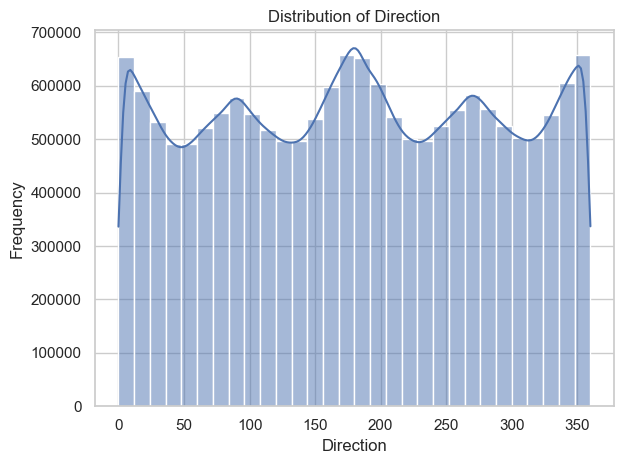

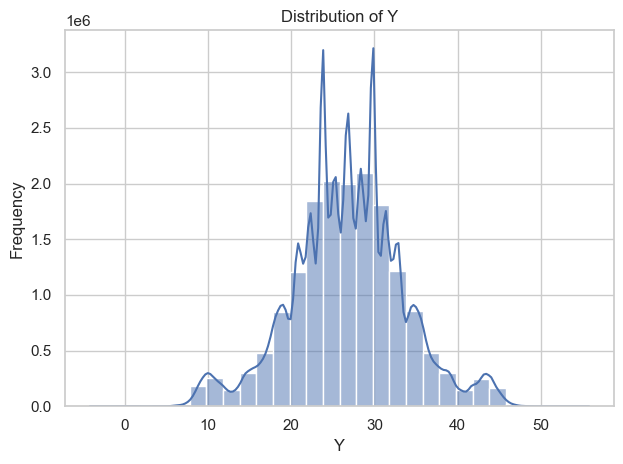

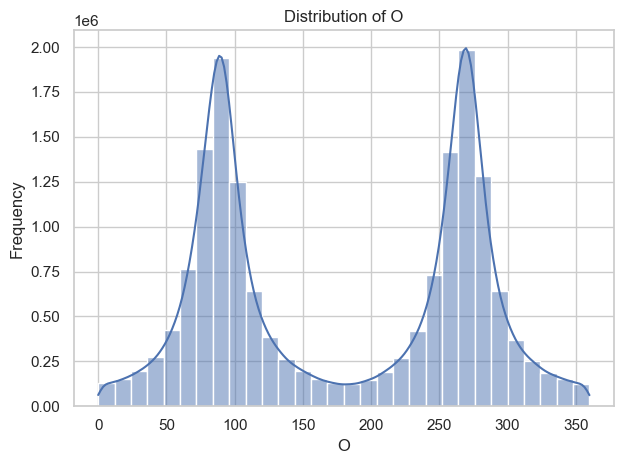

In [356]:
# print all unique values for each column in dataframes['all_tracking_data']
for column in dataframes['all_tracking_data'].columns:
    print(f"Unique values in '{column}': {dataframes['all_tracking_data'][column].unique()}")

# graph as a distribution of the direction column
sns.histplot(data=dataframes['all_tracking_data'], x='dir', bins=30, kde=True)
plt.title('Distribution of Direction')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# graph y distribution
sns.histplot(data=dataframes['all_tracking_data'], x='y', bins=30, kde=True)
plt.title('Distribution of Y')
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# graph o distribution
sns.histplot(data=dataframes['all_tracking_data'], x='o', bins=30, kde=True)
plt.title('Distribution of O')
plt.xlabel('O')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [357]:
# Drop all left-going plays from the all_tracking_data DataFrame
dataframes['all_tracking_data'] = dataframes['all_tracking_data'][dataframes['all_tracking_data']['playDirection'] != 'right']

In [358]:
print(dataframes['all_tracking_data']['playDirection'].unique())

['left']


### Categorizing the Running data plays

In [359]:
print(len(dataframes['all_tracking_data']))

8604684


In [360]:
# Filter plays for run outcomes and identify runners who had a rush attempt
runners_run_plays = pd.merge(
    players_df[players_df['hadRushAttempt'] == 1][['gameId', 'playId', 'nflId']],
    plays_df[plays_df['passResult'] == 'Run'][['gameId', 'playId', 'down']],
    on=['gameId', 'playId'],
    how='inner'
)

# Merge with tracking data and sort
runner_tracking = pd.merge(runners_run_plays, dataframes['all_tracking_data'], on=['gameId', 'playId', 'nflId'], how='left').sort_values(['gameId', 'playId', 'nflId', 'frameId', 'club'])

# Define field dimensions and thresholds
FIELD_WIDTH = 53.3  # Width of the football field in yards
CENTER_TOLERANCE = 10.0  # Tolerance for determining if a run is considered 'center'

# Calculate net movement and categorize direction based on the last frame
final_movement = runner_tracking.groupby(['gameId', 'playId', 'nflId']).agg(
    net_movement=('dir', lambda x: x.iloc[-1] - x.iloc[0]),
    down=('down', 'first'),
    last_direction=('dir', 'last')  # Get the last direction of the runner
).reset_index()

print(runner_tracking.head(50))

# Categorize the direction of the run based on the last direction
final_movement['direction'] = final_movement['last_direction'].apply(
    lambda x: 'RUN CENTER' if abs(x - 90) <= CENTER_TOLERANCE else
               'RUN OUTSIDE LEFT' if (x > 90 and x < 135) else
               'RUN INSIDE LEFT' if (x >= 135 and x < 270) else
               'RUN OUTSIDE RIGHT' if (x < 45 or x > 270 and x < 45) else
               'RUN INSIDE RIGHT'
)

# Add final_movement to plays_df where gameId and playId match
plays_df = pd.merge(plays_df, final_movement, on=['gameId', 'playId'], how='left')
plays_df.drop(columns=['down_y'], inplace=True)
plays_df.rename(columns={'down_x': 'down'}, inplace=True)

# Print the first 50 rows of plays_df for inspection
print(plays_df.head(50))

        gameId  playId  nflId  down  frameId club      x      y     event  \
0   2022090800     299  47853     1      NaN  NaN    NaN    NaN       NaN   
1   2022090800     343  47853     2      NaN  NaN    NaN    NaN       NaN   
2   2022090800    1406  47853     1      1.0   LA  25.24  23.46  No Event   
3   2022090800    1406  47853     1      2.0   LA  25.13  23.45  No Event   
4   2022090800    1406  47853     1      3.0   LA  25.03  23.44  No Event   
5   2022090800    1406  47853     1      4.0   LA  24.94  23.43  No Event   
6   2022090800    1406  47853     1      5.0   LA  24.85  23.43  No Event   
7   2022090800    1406  47853     1      6.0   LA  24.76  23.43  No Event   
8   2022090800    1406  47853     1      7.0   LA  24.69  23.43  No Event   
9   2022090800    1406  47853     1      8.0   LA  24.62  23.44  No Event   
10  2022090800    1406  47853     1      9.0   LA  24.56  23.45  No Event   
11  2022090800    1406  47853     1     10.0   LA  24.52  23.46  No Event   

In [361]:
# print unique values for each column in plays_df
for column in plays_df.columns:
    print(f"Unique values in '{column}': {plays_df[column].unique()}")


Unique values in 'gameId': [2022091809 2022103004 2022100212 2022100913 2022100900 2022091109
 2022102302 2022092511 2022100908 2022101600 2022091811 2022100208
 2022103001 2022100213 2022091106 2022091810 2022110300 2022092507
 2022091110 2022092600 2022103003 2022100204 2022100209 2022091112
 2022110604 2022092508 2022102309 2022101611 2022101601 2022110606
 2022100902 2022091108 2022091803 2022100901 2022101300 2022102300
 2022090800 2022102000 2022092505 2022092502 2022110601 2022092501
 2022101609 2022110605 2022101604 2022110603 2022102301 2022103009
 2022091801 2022103007 2022100211 2022102307 2022110607 2022091802
 2022091500 2022101610 2022102310 2022100201 2022100200 2022103002
 2022091113 2022091807 2022100907 2022092513 2022102306 2022101000
 2022101605 2022101602 2022100903 2022100205 2022102304 2022091900
 2022100600 2022101606 2022092900 2022091102 2022091103 2022101607
 2022110609 2022092503 2022110610 2022091104 2022100911 2022103012
 2022102700 2022092510 2022110700 2

In [362]:
# fill null values in routeRan with 'None'
players_df['routeRan'] = players_df['routeRan'].fillna('None')

In [363]:
print(players_df.head(50))

     hadRushAttempt  wasTargettedReceiver  rushingYards  hadDropback  \
66                0                     0             0            0   
67                0                     0             0            0   
68                0                     0             0            0   
69                0                     0             0            0   
70                0                     0             0            0   
71                0                     0             0            1   
72                0                     1             0            0   
73                0                     0             0            0   
74                0                     0             0            0   
75                0                     0             0            0   
76                0                     0             0            0   
77                0                     0             0            0   
78                0                     0             0         

In [364]:
# Filter plays for pass outcomes

# First get targeted receivers
targeted_receivers = players_df[players_df['wasTargettedReceiver'] == 1][['gameId', 'playId', 'nflId']]

# Get pass plays
pass_plays = plays_df[plays_df['passResult'] != 'Run'].copy()

# Merge targeted receivers with pass plays
pass_plays = pd.merge(
    targeted_receivers,
    pass_plays,
    on=['gameId', 'playId'],
    how='inner',
    suffixes=('', '_play')  # Avoid duplicate column names
)

# Get play directions
play_directions = dataframes['all_tracking_data'][['gameId', 'playId', 'nflId', 'playDirection']].drop_duplicates()

# Merge play directions
pass_plays = pd.merge(
    pass_plays,
    play_directions,
    on=['gameId', 'playId', 'nflId'],
    how='left'
)

# Fill null values in playDirection
pass_plays['playDirection'] = pass_plays['playDirection'].fillna(pass_plays.groupby(['gameId', 'playId'])['playDirection'].transform('first'))

# Define field dimensions
FIELD_WIDTH = 53.3    # Field width in yards
CENTER_LINE_Y = FIELD_WIDTH / 2  # 26.65 yards
CENTER_TOLERANCE = 2.0      # ±2 yards for center categorization

print(pass_plays.head(50))

# Use targetY to calculate the pass direction, assuming the player is always in the center of the field = 53.3/2 = 26.65
pass_plays['pass_direction'] = np.where(
    (pass_plays['playDirection'].str.lower() == 'left') & (pass_plays['targetY'] < CENTER_LINE_Y - CENTER_TOLERANCE),
    'LEFT',
    np.where(
        (pass_plays['playDirection'].str.lower() == 'left') & (pass_plays['targetY'] >= CENTER_LINE_Y - CENTER_TOLERANCE) & (pass_plays['targetY'] <= CENTER_LINE_Y + CENTER_TOLERANCE),
        'CENTER',
        'CENTER'  # Default to CENTER if not left
    )
)

# Categorize pass length
pass_plays['pass_type'] = np.where(
    pass_plays['passLength'].notna(),
    np.where(
        pass_plays['passLength'] <= 5, 'SHORT_PASS',
        np.where(pass_plays['passLength'] <= 15, 'MEDIUM_PASS', 'DEEP_PASS')
    ),
    'MEDIUM_PASS'  # Default if passLength is NaN
)

# Adjust targetY based on playDirection
pass_plays['adjusted_targetY'] = np.where(
    pass_plays['playDirection'].str.lower() == 'left',
    FIELD_WIDTH - pass_plays['targetY'],
    pass_plays['targetY']
)

# Categorize pass direction based on adjusted_targetY
conditions = [
    (pass_plays['adjusted_targetY'] < 13.325),
    (pass_plays['adjusted_targetY'] < 26.65 - CENTER_TOLERANCE),
    (pass_plays['adjusted_targetY'] > 41.975) & (pass_plays['adjusted_targetY'] <= 53.3),
    (pass_plays['adjusted_targetY'] > 26.65 + CENTER_TOLERANCE) & (pass_plays['adjusted_targetY'] <= 41.975),
    (pass_plays['adjusted_targetY'] >= 24.65) & (pass_plays['adjusted_targetY'] <= 28.65)  # Center with tolerance
]

choices = [
    'OUTSIDE',
    'INSIDE',
    'OUTSIDE',
    'INSIDE',
    'CENTER'
]

pass_plays['pass_direction'] = np.select(conditions, choices, default='CENTER')

# Add left/right prefix based on adjusted_targetY
pass_plays['pass_direction'] = np.where(
    (pass_plays['adjusted_targetY'] < CENTER_LINE_Y - CENTER_TOLERANCE) & (pass_plays['pass_direction'] != 'CENTER'),
    'LEFT_' + pass_plays['pass_direction'],
    np.where(
        (pass_plays['adjusted_targetY'] > CENTER_LINE_Y + CENTER_TOLERANCE) & (pass_plays['pass_direction'] != 'CENTER'),
        'RIGHT_' + pass_plays['pass_direction'],
        pass_plays['pass_direction']
    )
)

        gameId  playId  nflId  down  yardsToGo  absoluteYardlineNumber  \
0   2022090800     364  44881     3          8                      29   
1   2022090800    1427  44881     2          4                      14   
2   2022090800    1967  47853     2          8                      23   
3   2022090800    2208  47857     2          3                      25   
4   2022090800    3674  43399     3         14                      26   
5   2022090800    3696  41290     4         14                      26   
6   2022091100     572  52942     1         10                      21   
7   2022091100    3028  45355     2          9                      19   
8   2022091100    3050  52489     3          9                      19   
9   2022091100    3446  54476     1         10                      24   
10  2022091100    4032  41292     1         10                      30   
11  2022091101     109  43808     3         15                      27   
12  2022091101     748  46093     1   

In [365]:
# for each column in pass_plays, print the unique values
for column in pass_plays.columns:
    print(f"Unique values in '{column}': {pass_plays[column].unique()}")


Unique values in 'gameId': [2022090800 2022091100 2022091101 2022091102 2022091103 2022091104
 2022091105 2022091106 2022091107 2022091108 2022091109 2022091110
 2022091111 2022091112 2022091113 2022091200 2022091500 2022091800
 2022091801 2022091802 2022091803 2022091804 2022091805 2022091806
 2022091807 2022091808 2022091809 2022091810 2022091811 2022091812
 2022091900 2022091901 2022092200 2022092500 2022092501 2022092502
 2022092503 2022092504 2022092505 2022092506 2022092507 2022092508
 2022092509 2022092510 2022092511 2022092512 2022092513 2022092600
 2022092900 2022100200 2022100201 2022100202 2022100203 2022100204
 2022100205 2022100206 2022100207 2022100208 2022100209 2022100210
 2022100211 2022100212 2022100213 2022100300 2022100600 2022100900
 2022100901 2022100902 2022100903 2022100904 2022100905 2022100906
 2022100907 2022100908 2022100909 2022100910 2022100911 2022100912
 2022100913 2022101000 2022101300 2022101600 2022101601 2022101602
 2022101603 2022101604 2022101605 2

In [366]:
pass_plays['play_description'] = (
    pass_plays['pass_type'].where(pass_plays['pass_type'].notna(), '') + '/' +
    pass_plays['pass_direction'].where(pass_plays['pass_direction'].notna(), '')
).str.replace(r'/+', '/', regex=True).str.strip('/')

In [367]:
# Add pass_plays to plays_df where gameId and playId match, and leave null values in the new column being created
plays_df = pd.merge(plays_df, pass_plays[['gameId', 'playId', 'play_description']], on=['gameId', 'playId'], how='left')
# change name of direction to run_direction

for column in plays_df.columns:
    print(f"Unique values in '{column}': {plays_df[column].unique()}")


Unique values in 'gameId': [2022091809 2022103004 2022100212 2022100913 2022100900 2022091109
 2022102302 2022092511 2022100908 2022101600 2022091811 2022100208
 2022103001 2022100213 2022091106 2022091810 2022110300 2022092507
 2022091110 2022092600 2022103003 2022100204 2022100209 2022091112
 2022110604 2022092508 2022102309 2022101611 2022101601 2022110606
 2022100902 2022091108 2022091803 2022100901 2022101300 2022102300
 2022090800 2022102000 2022092505 2022092502 2022110601 2022092501
 2022101609 2022110605 2022101604 2022110603 2022102301 2022103009
 2022091801 2022103007 2022100211 2022102307 2022110607 2022091802
 2022091500 2022101610 2022102310 2022100201 2022100200 2022103002
 2022091113 2022091807 2022100907 2022092513 2022102306 2022101000
 2022101605 2022101602 2022100903 2022100205 2022102304 2022091900
 2022100600 2022101606 2022092900 2022091102 2022091103 2022101607
 2022110609 2022092503 2022110610 2022091104 2022100911 2022103012
 2022102700 2022092510 2022110700 2

In [368]:
plays_df['play_type_detailed'] = plays_df['play_description'].combine_first(plays_df['direction'])
plays_df.drop(columns=['play_description', 'direction'], inplace=True)

In [369]:
#print all unique values for each column in plays_df
for column in plays_df.columns:
    print(f"Unique values in '{column}': {plays_df[column].unique()}")

#save plays_df to dataframes dictionary
dataframes['plays_df.csv'] = plays_df

Unique values in 'gameId': [2022091809 2022103004 2022100212 2022100913 2022100900 2022091109
 2022102302 2022092511 2022100908 2022101600 2022091811 2022100208
 2022103001 2022100213 2022091106 2022091810 2022110300 2022092507
 2022091110 2022092600 2022103003 2022100204 2022100209 2022091112
 2022110604 2022092508 2022102309 2022101611 2022101601 2022110606
 2022100902 2022091108 2022091803 2022100901 2022101300 2022102300
 2022090800 2022102000 2022092505 2022092502 2022110601 2022092501
 2022101609 2022110605 2022101604 2022110603 2022102301 2022103009
 2022091801 2022103007 2022100211 2022102307 2022110607 2022091802
 2022091500 2022101610 2022102310 2022100201 2022100200 2022103002
 2022091113 2022091807 2022100907 2022092513 2022102306 2022101000
 2022101605 2022101602 2022100903 2022100205 2022102304 2022091900
 2022100600 2022101606 2022092900 2022091102 2022091103 2022101607
 2022110609 2022092503 2022110610 2022091104 2022100911 2022103012
 2022102700 2022092510 2022110700 2

In [370]:
print(plays_df.head(50))

        gameId  playId  down  yardsToGo  absoluteYardlineNumber  \
0   2022091809    3698     1         10                      18   
1   2022103004    3146     3         12                      30   
2   2022100212    2463     1          1                      11   
3   2022100913    2604     3          6                      30   
4   2022100900    3560     2          2                      29   
5   2022091109    2502     2          3                      13   
6   2022102302    1437     3          1                      11   
7   2022092511    2008     3          3                      23   
8   2022100908     552     2          3                      27   
9   2022101600     177     3          1                      30   
10  2022101600    1215     2          9                      24   
11  2022091811    4032     2          3                      13   
12  2022100908    2253     3         11                      27   
13  2022100208    1348     2          6                      1

### Delete individual tracking DataFrames from the dictionary

In [371]:
# Delete individual tracking DataFrames from the dictionary
for file in tracking_files:
    del dataframes[file]

# Print the rows with null values
print(dataframes['all_tracking_data'][dataframes['all_tracking_data'].isnull().any(axis=1)])

# Print the head and description of the combined tracking data
print(dataframes['all_tracking_data'].head(), dataframes['all_tracking_data'].describe(), sep='\n')


Empty DataFrame
Columns: [gameId, playId, nflId, frameId, club, x, y, event, playDirection, s, a, o, dir, dis]
Index: []
          gameId  playId    nflId  frameId club      x      y  \
5478  2022101000     181  38551.0        1   LV  88.16  20.46   
5479  2022101000     181  38551.0        2   LV  88.14  20.32   
5480  2022101000     181  38551.0        3   LV  88.11  20.18   
5481  2022101000     181  38551.0        4   LV  88.08  20.04   
5482  2022101000     181  38551.0        5   LV  88.05  19.91   

                     event playDirection     s     a      o     dir   dis  
5478  huddle_break_offense          left  1.28  0.43  11.34  187.34  0.14  
5479              No Event          left  1.32  0.42  14.53  189.33  0.14  
5480              No Event          left  1.34  0.43  17.00  192.26  0.14  
5481              No Event          left  1.34  0.36  19.72  192.56  0.14  
5482              No Event          left  1.36  0.23  21.85  192.12  0.14  
             gameId        playI

In [372]:
# how many rows are in dataframes['all_tracking_data']
print(len(dataframes['all_tracking_data']))

8604684


## Merge Datasets

In [373]:
# plays_df, players_df, and tracking_merged_df - print unique values for each column
for column in plays_df.columns:
    print(f"Unique values in '{column}'")
for column in players_df.columns:
    print(f"Unique values in '{column}'")
for column in dataframes['all_tracking_data'].columns:
    print(f"Unique values in '{column}'")


Unique values in 'gameId'
Unique values in 'playId'
Unique values in 'down'
Unique values in 'yardsToGo'
Unique values in 'absoluteYardlineNumber'
Unique values in 'offenseFormation'
Unique values in 'receiverAlignment'
Unique values in 'passResult'
Unique values in 'passLength'
Unique values in 'targetX'
Unique values in 'targetY'
Unique values in 'unblockedPressure'
Unique values in 'prePenaltyYardsGained'
Unique values in 'isDropback'
Unique values in 'defenseFormation'
Unique values in 'expectedPointsAdded'
Unique values in 'defensiveTeam'
Unique values in 'possessionTeam'
Unique values in 'nflId'
Unique values in 'net_movement'
Unique values in 'last_direction'
Unique values in 'play_type_detailed'
Unique values in 'hadRushAttempt'
Unique values in 'wasTargettedReceiver'
Unique values in 'rushingYards'
Unique values in 'hadDropback'
Unique values in 'passingYards'
Unique values in 'wasRunningRoute'
Unique values in 'routeRan'
Unique values in 'pff_defensiveCoverageAssignment'
Uniq

In [374]:
# Merge plays_df with players_df on gameId and playId to combine relevant player data
merged_df = pd.merge(plays_df, players_df, on=['gameId', 'playId'], how='left')

# Rename the column for consistency
merged_df = merged_df.rename(columns={'nflId_y': 'nflId'})

# Merge the tracking data with the merged_df on gameId, playId, and nflId
merged_df = pd.merge(dataframes['all_tracking_data'], merged_df, on=['gameId', 'playId', 'nflId'], how='left')


# Keep rows where the club is equal to the defensive team for the same playId
merged_df = merged_df[merged_df['club'] == merged_df['defensiveTeam']]
merged_df = merged_df[merged_df['playId'].isin(merged_df[merged_df['club'] == merged_df['defensiveTeam']]['playId'])]

# Remove any rows with missing values

# Print unique values for each column in the merged dataframe
for column in merged_df.columns:
    print(f"Unique values for '{column}': {merged_df[column].unique()}")

# for playIds in merged_df, fill in with the first value that has the same playId as the rest
merged_df['playId'] = merged_df.groupby('gameId')['playId'].fillna(method='ffill')

# Store the final merged dataframe
tracking_merged_df = merged_df

print(tracking_merged_df.head(50))

# Display specific columns from the original tracking data
print(dataframes['all_tracking_data'][['gameId', 'playId', 'nflId']].astype({'nflId': 'int'}))

# Print the number of rows in the final merged dataframe
print(len(tracking_merged_df))


Unique values for 'gameId': [2022101000 2022100913 2022100912 2022100911 2022100910 2022100909
 2022100908 2022100907 2022100906 2022100905 2022100904 2022100903
 2022100902 2022100901 2022100900 2022100600 2022100300 2022100213
 2022100212 2022100211 2022100203 2022100210 2022100209 2022100208
 2022100207 2022100206 2022100205 2022100204 2022100202 2022100201
 2022100200 2022092900 2022101700 2022101611 2022101610 2022101609
 2022101608 2022101607 2022101606 2022101605 2022101604 2022101603
 2022101602 2022101601 2022101600 2022101300 2022102400 2022102310
 2022102309 2022102308 2022102307 2022102306 2022102305 2022102304
 2022102303 2022102302 2022102301 2022102300 2022102000 2022092600
 2022092513 2022092512 2022092511 2022092510 2022092509 2022092508
 2022092507 2022092506 2022092505 2022092504 2022092503 2022092502
 2022092501 2022092500 2022092200 2022091901 2022091900 2022091812
 2022091811 2022091810 2022091809 2022091808 2022091807 2022091806
 2022091805 2022091804 2022091803 

/var/folders/gz/zygkt4mn4sd0g24rh8vb0z940000gn/T/ipykernel_10743/2413231148.py:22: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  merged_df['playId'] = merged_df.groupby('gameId')['playId'].fillna(method='ffill')
/var/folders/gz/zygkt4mn4sd0g24rh8vb0z940000gn/T/ipykernel_10743/2413231148.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['playId'] = merged_df.groupby('gameId')['playId'].fillna(method='ffill')


           gameId  playId    nflId  frameId club      x      y  \
12094  2022101000     893  42406.0        1   KC  24.29  28.41   
12095  2022101000     893  42406.0        2   KC  24.32  28.37   
12096  2022101000     893  42406.0        3   KC  24.34  28.32   
12097  2022101000     893  42406.0        4   KC  24.36  28.26   
12098  2022101000     893  42406.0        5   KC  24.37  28.21   
12099  2022101000     893  42406.0        6   KC  24.38  28.14   
12100  2022101000     893  42406.0        7   KC  24.39  28.07   
12101  2022101000     893  42406.0        8   KC  24.43  27.99   
12102  2022101000     893  42406.0        9   KC  24.46  27.91   
12103  2022101000     893  42406.0       10   KC  24.49  27.82   
12104  2022101000     893  42406.0       11   KC  24.51  27.72   
12105  2022101000     893  42406.0       12   KC  24.53  27.61   
12106  2022101000     893  42406.0       13   KC  24.55  27.51   
12107  2022101000     893  42406.0       14   KC  24.57  27.41   
12108  202

In [375]:
# Count rows in tracking_merged_df
print(f"Number of rows in tracking_merged_df: {len(tracking_merged_df)}")

Number of rows in tracking_merged_df: 1314148


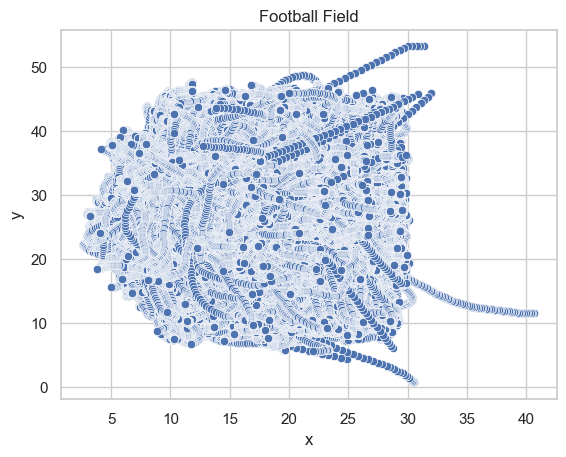

In [376]:
# For each dataframes[all_tracking_data], graph in a football field all of the x and y coordinates for each frameId
sns.scatterplot(data=tracking_merged_df, x='x', y='y', legend=False)
plt.title('Football Field')
plt.show()

### Data Cleaning

In [377]:
# Fill wasRunningRoute with 0
merged_df['wasRunningRoute'] = merged_df['wasRunningRoute'].fillna(0)

# Drop all rows with no route
merged_df = merged_df[merged_df['routeRan'].notna()]

# Print all columns in merged_df that have null values
print(merged_df.columns[merged_df.isnull().any()])

# Print all unique values in the columns that have null values
for column in merged_df.columns[merged_df.isnull().any()]:
    print(f"Unique values in '{column}': {merged_df[column].unique()}")
    #print datatypes of the columns
    print(f"Data types in '{column}': {merged_df[column].dtype}")

Index(['nflId_x', 'net_movement', 'last_direction', 'play_type_detailed'], dtype='object')
Unique values in 'nflId_x': [54587.    nan 47807. 52440. 41325. 42469. 46101. 52460. 47836. 52630.
 46377. 43334. 44816. 54616. 53612. 53536. 54501. 54506. 44879. 53549.
 44853. 47856. 52520. 45573. 44898. 46076. 46071. 45186. 54577. 44995.
 42358. 46830. 40078. 44822. 54556. 54716. 38605. 52470. 47870. 47784.
 53478. 44917. 53453. 52733. 52461. 53579. 53646. 52449. 54572. 43722.
 52474. 47896. 47857. 46104. 37110. 40129. 52430. 44860. 42718. 46270.
 40011. 42837. 53678. 43362. 37101. 44978. 53454. 53703. 54648. 54515.
 42345. 54042. 42416. 54536. 54563. 53440. 54558. 44852. 46173. 52708.
 47911. 43293. 44947. 53555. 46437. 54666. 39975. 46096. 44835. 45102.
 53434. 52463. 52500. 48233. 46203. 44814. 46526. 53464. 52425. 53117.
 53432. 47853. 54905. 53430. 46100. 52457. 53623. 47819. 44820. 45244.
 43525. 54551. 54475. 53000. 46238. 47842. 52443. 44927. 44990. 44901.
 52581. 47605. 44985. 54528. 

## Review unique values in each column

In [1]:
tracking_merged_df.to_csv('final_dataframe.csv', index=False)

NameError: name 'tracking_merged_df' is not defined

In [2]:
import pandas as pd
tracking_merged_df = pd.read_csv('final_dataframe.csv')


In [10]:
# print all columns
print(tracking_merged_df.columns)

Index(['gameId', 'playId', 'nflId', 'frameId', 'club', 'x', 'y', 'event',
       'playDirection', 's', 'a', 'o', 'dir', 'dis', 'down', 'yardsToGo',
       'absoluteYardlineNumber', 'offenseFormation', 'receiverAlignment',
       'passResult', 'passLength', 'targetX', 'targetY', 'unblockedPressure',
       'prePenaltyYardsGained', 'isDropback', 'defenseFormation',
       'expectedPointsAdded', 'defensiveTeam', 'possessionTeam', 'nflId_x',
       'net_movement', 'last_direction', 'play_type_detailed',
       'hadRushAttempt', 'wasTargettedReceiver', 'rushingYards', 'hadDropback',
       'passingYards', 'wasRunningRoute', 'routeRan',
       'pff_defensiveCoverageAssignment'],
      dtype='object')


In [3]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel

# Prepare features and target variable
features = tracking_merged_df.drop(columns=['prePenaltyYardsGained', 'expectedPointsAdded', 'net_movement', 'nflId_x'])
target = tracking_merged_df['prePenaltyYardsGained']

# Convert categorical columns to category dtype
categorical_cols = ['club', 'event', 'playDirection', 'offenseFormation', 'receiverAlignment', 
                    'passResult', 'defenseFormation', 'defensiveTeam', 'possessionTeam', 
                    'play_type_detailed', 'pff_defensiveCoverageAssignment']

for col in categorical_cols:
    if col in features.columns:
        features[col] = features[col].astype('category')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the XGBoost model with enable_categorical set to True
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01, enable_categorical=True)

# Train the model
xgb_model.fit(X_train, y_train)

# Feature importance
importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display all feature importance
print("Feature Importances:")
print(feature_importance_df)


# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"Root Mean Squared Error: {rmse:.2f}")


Feature Importances:
                            Feature  Importance
19                       passResult    0.524833
20                       passLength    0.165273
22                          targetY    0.071805
16           absoluteYardlineNumber    0.043701
23                unblockedPressure    0.042642
27                   possessionTeam    0.028720
4                              club    0.020667
17                 offenseFormation    0.015686
25                 defenseFormation    0.013347
15                        yardsToGo    0.013026
14                             down    0.011957
28                   last_direction    0.011632
21                          targetX    0.010446
29               play_type_detailed    0.010399
18                receiverAlignment    0.008636
1                            playId    0.004874
0                            gameId    0.002169
5                                 x    0.000186
3                           frameId    0.000000
36                 

In [393]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def aggregate_play_features(dataframe):
    """Aggregate multiple frames per play into single feature vector"""
    # Group by playId and gameId and calculate relevant statistics
    play_features = dataframe.groupby(['playId', 'gameId']).agg({
        'x': ['mean', 'std', 'min', 'max'],  # Position stats
        'y': ['mean', 'std', 'min', 'max'],
        'dir': ['mean', 'std'],  # Direction stats
        'dis': ['mean', 'sum'],  # Distance stats
        'o': ['mean']  # Orientation stats
    }).reset_index()
    
    return play_features

def train_models(X_train, y_train, X_test, y_test):
    """Train and evaluate multiple regression models"""
    models = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'SVM': SVR()
    }
    
    # Fine-tune RandomForest hyperparameters using Grid Search
    param_grid_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20]
    }
    grid_search_rf = GridSearchCV(models['RandomForest'], param_grid_rf, cv=5)
    grid_search_rf.fit(X_train, y_train)
    models['RandomForest'] = grid_search_rf.best_estimator_

    # Fine-tune SVM hyperparameters using Grid Search
    param_grid_svm = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'epsilon': [0.1, 0.2, 0.5],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    grid_search_svm = GridSearchCV(models['SVM'], param_grid_svm, cv=5)
    grid_search_svm.fit(X_train, y_train)
    models['SVM'] = grid_search_svm.best_estimator_

    results = {}
    
    for name, model in models.items():
        logging.info(f"Training {name}...")
        
        # Train on full training set
        model.fit(X_train, y_train)
        
        # Cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        cv_rmse_scores = np.sqrt(-cv_scores)
        logging.info(f"Cross-validation RMSE scores: {cv_rmse_scores}")
        logging.info(f"Average CV RMSE: {cv_rmse_scores.mean():.3f} (+/- {cv_rmse_scores.std() * 2:.3f})")
        
        # Evaluate on test set
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        logging.info(f"{name} Test RMSE: {rmse:.3f}")
        logging.info(f"{name} Test MAE: {mae:.3f}")
        logging.info(f"{name} Test R-squared: {r2:.3f}")
        
        results[name] = {
            'model': model,
            'cv_rmse_scores': cv_rmse_scores,
            'test_rmse': rmse,
            'test_mae': mae,
            'test_r2': r2
        }
    
    return results

def recommend_play_type(models, situation_features, play_types, top_n=3):
    """Get play type recommendations that maximize expected yards gained"""
    recommendations = []
    
    for play_type in play_types:
        # Create copy of situation features for this play type
        features = situation_features.copy()
        # Overwrite the 'play_type_detailed' feature
        features['play_type_detailed'] = play_type
        
        # Ensure the features match the model's expected input
        features = features[models['RandomForest']['model'].feature_names_in_]
        
        # Predict expected yards gained for each model
        expected_yards = {}
        for name, model_dict in models.items():
            model = model_dict['model']
            predicted_yards = model.predict(features)[0]
            expected_yards[name] = predicted_yards
        
        # Average the expected yards from all models
        avg_expected_yards = np.mean(list(expected_yards.values()))
        
        recommendations.append({
            'play_type': play_type,
            'expected_yards': avg_expected_yards
        })
    
    # Sort recommendations by expected yards gained
    recommendations = sorted(recommendations, key=lambda x: x['expected_yards'], reverse=True)
    
    return recommendations[:top_n]

# Prepare the data
logging.info("Preparing data...")

play_features = aggregate_play_features(tracking_merged_df)

# Flatten multi-level column names
play_features.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in play_features.columns]

# Get target variable (prePenaltyYardsGained) and play type for each combination of playId and gameId
play_data = tracking_merged_df.groupby(['gameId', 'playId']).agg({
    'prePenaltyYardsGained': 'mean',
    'play_type_detailed': 'first'
}).reset_index()
play_features = play_features.rename(columns={'gameId_': 'gameId', 'playId_': 'playId'})

play_features = play_features.merge(play_data, on=['gameId', 'playId'])

# Filter out rows where target or play type is NA
play_features = play_features[play_features['prePenaltyYardsGained'].notna()]
play_features = play_features[play_features['play_type_detailed'].notna()]

# Implement minimum sampling for play_type_detailed
play_type_counts = play_features['play_type_detailed'].value_counts()
valid_play_types = play_type_counts[play_type_counts > 5].index
play_features = play_features[play_features['play_type_detailed'].isin(valid_play_types)]

# Split features and target
y = play_features['prePenaltyYardsGained']

# Encode play_type_detailed using LabelEncoder
le = LabelEncoder()
play_features['play_type_detailed'] = le.fit_transform(play_features['play_type_detailed'])

X = play_features.drop(['playId', 'gameId', 'prePenaltyYardsGained'], axis=1)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42
)

# Train and evaluate models
logging.info("Training models...")
model_results = train_models(X_train, y_train, X_test, y_test)

# Make predictions on the test set
y_pred = model_results['RandomForest']['model'].predict(X_test)

# Calculate metrics
# Since y_test is continuous, we should not use accuracy_score or f1_score
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Log the results
logging.info(f"Model Evaluation Metrics:")
logging.info(f"R-squared: {r2:.4f}")
logging.info(f"Mean Squared Error: {mse:.4f}")


2024-12-10 21:20:50,737 - INFO - Preparing data...
2024-12-10 21:20:50,957 - INFO - Training models...
2024-12-10 21:21:34,371 - INFO - Training RandomForest...
2024-12-10 21:21:40,751 - INFO - Cross-validation RMSE scores: [4.72451983 4.77185574 4.49937181 4.27667871 4.51988453]
2024-12-10 21:21:40,751 - INFO - Average CV RMSE: 4.558 (+/- 0.355)
2024-12-10 21:21:40,762 - INFO - RandomForest Test RMSE: 4.112
2024-12-10 21:21:40,762 - INFO - RandomForest Test MAE: 3.210
2024-12-10 21:21:40,762 - INFO - RandomForest Test R-squared: 0.176
2024-12-10 21:21:40,763 - INFO - Training SVM...
2024-12-10 21:21:40,856 - INFO - Cross-validation RMSE scores: [4.8068598  4.96988211 4.55943754 4.10575126 4.63531907]
2024-12-10 21:21:40,857 - INFO - Average CV RMSE: 4.615 (+/- 0.583)
2024-12-10 21:21:40,861 - INFO - SVM Test RMSE: 4.750
2024-12-10 21:21:40,861 - INFO - SVM Test MAE: 3.291
2024-12-10 21:21:40,862 - INFO - SVM Test R-squared: -0.099
2024-12-10 21:21:40,872 - INFO - Model Evaluation Metr

### Definition: R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. - SVM is negative so it is not a good model while Random Forest gives us a .176, which means the proportion of the variance in the dependent variable that is predictable from the independent variables.


# Testing some sample recommendations

In [399]:

# Generate recommendations for multiple sample situations
logging.info("Generating example recommendations...")
for i in range(30):  # Loop through 30 sample situations
    sample_situation = X_test.iloc[i:i+1].copy()  # Get the i-th sample situation
    unique_play_types = play_features['play_type_detailed'].unique()
    recommendations = recommend_play_type(model_results, sample_situation, unique_play_types)

    # Sort recommendations by expected yards gained
    recommendations = sorted(recommendations, key=lambda x: x['expected_yards'], reverse=True)

    # Log the top 3 recommendations
    logging.info(f"Top Play Type Recommendations for Sample Situation {i+1}:")
    for rec in recommendations[:3]:  # Get top 3 recommendations
        # Convert encoded play type back to original label
        play_type = le.inverse_transform([int(rec['play_type'])])[0]
        logging.info(f"Play Type: {play_type}, Expected Yards Gained: {rec['expected_yards']:.2f}")

2024-12-10 21:23:47,308 - INFO - Generating example recommendations...
2024-12-10 21:23:47,412 - INFO - Top Play Type Recommendations for Sample Situation 1:
2024-12-10 21:23:47,413 - INFO - Play Type: SHORT_PASS/RIGHT_OUTSIDE, Expected Yards Gained: 4.29
2024-12-10 21:23:47,413 - INFO - Play Type: SHORT_PASS/RIGHT_INSIDE, Expected Yards Gained: 4.27
2024-12-10 21:23:47,413 - INFO - Play Type: SHORT_PASS/LEFT_OUTSIDE, Expected Yards Gained: 4.25
2024-12-10 21:23:47,503 - INFO - Top Play Type Recommendations for Sample Situation 2:
2024-12-10 21:23:47,503 - INFO - Play Type: SHORT_PASS/RIGHT_OUTSIDE, Expected Yards Gained: 3.89
2024-12-10 21:23:47,503 - INFO - Play Type: SHORT_PASS/RIGHT_INSIDE, Expected Yards Gained: 3.86
2024-12-10 21:23:47,504 - INFO - Play Type: SHORT_PASS/LEFT_OUTSIDE, Expected Yards Gained: 3.83
2024-12-10 21:23:47,592 - INFO - Top Play Type Recommendations for Sample Situation 3:
2024-12-10 21:23:47,592 - INFO - Play Type: SHORT_PASS/LEFT_INSIDE, Expected Yards G

In [403]:
#print the quantity of data analyzed (plays)
print(f"Number of plays analyzed: {len(play_features)}")

Number of plays analyzed: 1074
